In [173]:
# Acá van las librerías que vamos a ocupar :)
import csv
import numpy as np                           # Útil para procesos matemáticos
from sympy import *                          # Útil para calcular derivadas 
from scipy.optimize import fsolve            # Útil para encontrar soluciónes númericas
from scipy.optimize import curve_fit         # Útil para fiteos de curvas 
from scipy.interpolate import interp1d       # Librería para hacer interpolaciones
import matplotlib.pyplot as plt              # Plotting 
import pickle                                # Útil para guardar datos y cargarlos después
from operator import itemgetter
from IPython.display import clear_output

## Proyecto Tarea 6

En este proyecto implementaremos la materia vista en manejo de portafolios de riesgo óptimo. Se nos entrega $\mu$ y $\sigma$ de 4 assets distintos denominados A, B, C y D, junto a una matriz de correlación entre cada uno de ellos, que obviamente es diagonal ya que la correlación entre A y B es igual a la correlación entre B y A. 

### a) Frontera Eficiente

En esta parte debemos escribir un programa que calcule la frontera eficiente de nuestro portafolio. Según lo visto en clases, dado un portafolio compuesto por $N$ assets, cada uno con su propio retorno $\mu_i$ y riesgo $\sigma_i$. Cada asset tendra un peso $W_i$ correspondiente a la fracción del total que representa y cada par tendra una correlación $\rho_{ij}$. Con estos datos, podemos calcular el retorno y riesgo del portafolio:

$$ \mu_\Pi = \sum_{i=1}^N W_i\mu_i,$$
$$ \sigma_\Pi = \sqrt{\sum_{i=1}^N\sum_{j=1}^N W_iW_j\rho_{ij}\sigma_i\sigma_j}.$$

La frontera corresponderá a la curva $\mu_\Pi$ vs $\sigma_\Pi$ que tenga mayor retorno, dado un riesgo definido. Nuestro deber entonces es encontrar el valor óptimo para los pesos. Esto se podría hacer mediante inteligencia artificial con una red neuronal de dos outputs y 4 inputs, pero quién tiene tiempo para esto al final del semestre? Ergó, como son solo 4 inputs procedo a generar todos los resultados posibles y identificar el $\mu$ óptimo para cada valor posible de $\sigma$ :)

In [2]:
# Partimos definiendo datos entregados:
# promedios y desviaciones assets en forma asset : (mu, epsilon)
assets_data = {'A': (0.08, 0.12), 'B': (0.1, 0.12), 'C': (0.10, 0.15), 'D': (0.14, 0.2)}
assets = assets_data.keys()

# Definimos pesos inciales iguales para todos
w_assets = {}
for a in assets: w_assets[a] = 1/len(assets)

# matriz de correlacion
rho = np.array([[1,0.2,0.5,0.3],[0.2,1,0.7,0.4],[0.5,0.7,1,0.9],[0.3,0.4,0.9,1]])

# Definimos funciónes de portafolio:
# Retorno de portafolio
def mu_pi(assets, assets_data, w_assets):
    mu = 0
    for a in assets:
        mu += w_assets[a]*assets_data[a][0]
    return mu

# Riesgo del portafolio
def sigma_pi(assets, assets_data, w_assets, rho=rho):
    assets = [a for a in assets]
    sigma = 0
    for a in assets:
        for b in assets:
            sigma += w_assets[a]*w_assets[b]*rho[assets.index(a)][assets.index(b)]*assets_data[a][1]*assets_data[b][1]
    return np.sqrt(sigma)

Debemos generar todos los pesos posibles sujetos a la restricción $\sum_i W_i=1$. Para esto voy a ser bruto y generar todos los pesos posibles dada cierta precision de 0 a 1, generar todas las combinaciones posibles entre ellos y filtrar las combinaciones que cumplan este constraint. No es la mejor manera, pero python goes brrrr.

In [139]:
# Todas las posibles combinaciones entre pesos
# t = 1 min para 0.01 puntos x peso 
def all_possible_w_combs(assets):
    assets = [a for a in assets]
    ws = np.arange(0,1.01,0.01)
    # Lord forgive me...
    return [{assets[0]:w1,assets[1]:w2,assets[2]:w3,assets[3]:w4} for w1 in ws for w2 in ws for w3 in ws for w4 in ws if w1+w2+w3+w4==1]

all_w_combs = all_possible_w_combs(assets)

In [153]:
# Calculamos mus y sigmas para estos pesos (t = 10 seg approx):
mu_sigs_w = [(mu_pi(assets,assets_data,ws),sigma_pi(assets,assets_data,ws),[w for w in ws.values()]) for ws in all_w_combs]

mus = [mu[0] for mu in mu_sigs_w]
sigs = [sig[1] for sig in mu_sigs_w]

# encontramos el mayor mu para cada sigma generado
def best_mu_for_sig(mu_sigs_w):
    best = {}
    for d in mu_sigs_w:
       if not best: 
          best[d[1]] = (d[0],d[2])
          continue
       sig = d[1]
       closest = min([k for k in best.keys()], key=lambda x:abs(x-sig))
       if np.abs(closest - d[1]) >= 0.0001: best[d[1]] = (d[0],d[2])
       else: 
           if d[0] >= best[closest][0]: best[closest] = (d[0],d[2])
    best_points = [(k[1][0], k[0], k[1][1]) for k in best.items()]
    return best_points

best_points = best_mu_for_sig(mu_sigs_w)
best_mus = [p[0] for p in best_points]
best_sigs = [p[1] for p in best_points]
best_pesos = [p[2] for p in best_points]

In [193]:
# Fit de curva para los puntos óptimos 
fit_values = np.polyfit(best_sigs,  best_mus, 15)

def fit_mu(t, fit=fit_values):
    polynomial = np.poly1d(fit)
    return  polynomial(t)

def derivative_fit_mu(t, fit=fit_values):
    polynomial = np.poly1d(fit).deriv(m=1)
    return  polynomial(t)

c:\Users\Eitan\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, '$\\mu_\\Pi$')

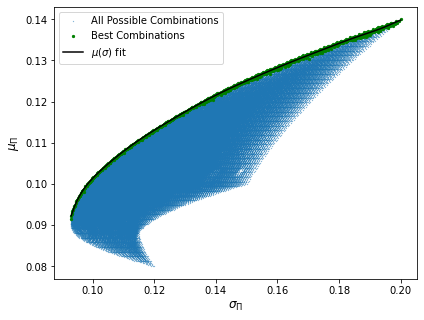

In [172]:
fig, ax = plt.subplots(figsize=(6.5,5))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
              
ax_all = ax.scatter(sigs, mus, s=.05, label='All Possible Combinations')
ax_best = ax.scatter(best_sigs, best_mus, s=5, color='green', label='Best Combinations')
ax_fit, = ax.plot(np.arange(0.093,0.2,0.001), [fit_mu(s) for s in np.arange(0.093,0.2,0.001)], color='black', label=r'$\mu(\sigma)$ fit')

ax.legend(handles=[ax_all, ax_best, ax_fit], prop={'size': 10})
ax.set_xlabel(r'$\sigma_\Pi$', size=12)
ax.set_ylabel(r'$\mu_\Pi$', size=12)

Obtenemos entonces la frontera óptima resaltando los puntos de mayor eficiencia para cada partición de sigma y fiteando un polinomio de grado 11 (grado óptimo determinado por la función en el anéxo) para rellenar vacios.

Dado esta podemos determinar los pesos para cada activo dado un punto en la recta con un error insignificante. Basta con encontrar el punto generado más cercano dentro de la frontera y extraer los pesos correspondientes. Voy a generar un archivo ''puntos_frontera_optima.csv'' para que vean estos puntos.

In [174]:
with open('puntos_frontera_optima.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['rentabilidad óptima', 'riesgo asociado', 'composicion de portafolio'])
    for p in best_points:
        writer.writerow([p[0],p[1],p[2]])

### Parte b)

Se nos pide encontrar donde debemos ubicarnos en la frontera eficiente, si es que queremos minimizar la probabilidad de tener un retorno menor a 5%. Para esto, basta con encontrar la recta tangente a la frontera que pase por la rentabilidad de 5% en riesgo 0. 

Matematicamente hablando, dada la función $f'(x)$ para nuestro fit y riesgo $r$,

$$ m = f'(x) = \frac{f(x)-0}{x-r} \implies f(x)+f'(x)(r-x)=0 .$$

Resolviendo para $(x, f(x))$ tendremos el punto de la frontera efficiente que corresponde a este riesgo. 

In [195]:
def tangent_vals(rent=0.05):
    xs = np.arange(0.093,0.2,0.0001)
    ys = sorted([(np.abs(derivative_fit_mu(tr)*(rent-tr)+fit_mu(tr)),tr) for tr in xs])
    print(ys)
    t1 = ys[0][1]
    print(t1)
    return (derivative_fit_mu(t1), t1)

def tangent(t, m, t1):
    return m*(t-t1)+fit_mu(t1)

m,t1 = tangent_vals(rent=0.05)
print(tangent(0, m, t1))

[(0.00011764520197392325, 0.09340000000000001), (0.0019655234319994747, 0.09330000000000001), (0.00214820435158615, 0.09350000000000001), (0.004102393730073525, 0.0932), (0.004127230141297303, 0.09360000000000002), (0.006055782833119125, 0.09370000000000002), (0.006294073884053064, 0.0931), (0.007934907050170262, 0.09380000000000002), (0.008541688457815319, 0.093), (0.009765631717437606, 0.09390000000000003), (0.011548970375977616, 0.09400000000000003), (0.013285921338005519, 0.09410000000000003), (0.014977467541357994, 0.09420000000000003), (0.016624577084887224, 0.09430000000000004), (0.01822820304239206, 0.09440000000000004), (0.01978928373762022, 0.09450000000000004), (0.02130874292184956, 0.09460000000000005), (0.022787489791718615, 0.09470000000000005), (0.02422641916790809, 0.09480000000000005), (0.025626411751771147, 0.09490000000000005), (0.026988333996268835, 0.09500000000000006), (0.028313038575669552, 0.09510000000000006), (0.029601364266626393, 0.09520000000000006), (0.030

Text(0, 0.5, '$\\mu_\\Pi$')

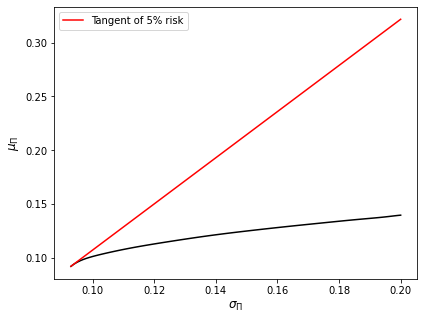

In [192]:
fig, ax = plt.subplots(figsize=(6.5,5))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
              
ax_fit, = ax.plot(np.arange(0.093,0.2,0.001), [fit_mu(s) for s in np.arange(0.093,0.2,0.001)], color='black', label=r'$\mu(\sigma)$ fit')
ax_fit, = ax.plot(np.arange(0.093,0.2,0.001), [tangent(s, m, t1) for s in np.arange(0.093,0.2,0.001)], color='red', label=r'Tangent of 5% risk')


ax.legend(handles=[ax_fit], prop={'size': 10})
ax.set_xlabel(r'$\sigma_\Pi$', size=12)
ax.set_ylabel(r'$\mu_\Pi$', size=12)

## Anexo: Funciones Citadas

In [ ]:
# Función para encontrar grado óptimo de fiteo (Gracias Chat GPT :P)
# Con esta función encontre el grado del polinomio a ajustar en a) 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def best_degree(x, y, max_degree=15):
    """
    Given x, y values return the best degree for polynomial fit
    :param x: x values
    :param y: y values
    :param max_degree: maximum degree to consider for the polynomial
    :return: best degree
    """
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Initialize variables
    best_degree = 0
    best_mse = np.inf

    # Try different degrees
    for degree in range(1, max_degree+1):  # range could be adjusted based on specific requirements
        # Fit the polynomial on train data
        coefficients = np.polyfit(x_train, y_train, degree)

        # Use the coefficients to create a polynomial function
        polynomial = np.poly1d(coefficients)

        # Generate y values for fitted function on test data
        y_poly = polynomial(x_test)

        # Compute mean squared error
        mse = mean_squared_error(y_test, y_poly)

        # If current degree gives lower error, update best degree and best mse
        if mse < best_mse:
            best_degree = degree
            best_mse = mse

    return best_degree


print("Best degree: ", best_degree(best_sigs, best_mus, max_degree=100))